# TODO
* [ ] Agregar el ejemplo utilizando una GAN
* [ ] Correrlo con `max_iter = 5_000`
* [ ] Hacer la versión Batch
* [ ] Hacer la versión proyectada

Notebook que sirve de ejemplo para calcular el baricentro de un conjunto de datos de imágenes.

# Configuraciones iniciales

## Constantes

In [1]:
CLEAN_LOGS = True  # If you want to clean the logs directory
SAVE_FIGS = True  # If you want to save the figures.

S_k = 10  # Batch size
REPORT_EVERY = 100  # To report at the logger
MAX_ITER = 5_000  # MAx number of iterations for the SGDW
MAX_ITER_PROJ = MAX_ITER
MAX_IMGS = 22 * 4
MAX_ITER = MAX_IMGS; REPORT_EVERY = 5  # Descomentar para debuguear
# MAX_ITER = MAX_IMGS  # Descomentar para debuguear

In [2]:
import torch
import numpy as np
import random

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
from pathlib import Path
from icecream import ic


DS_NAME = "data"

CURR_PATH = Path().absolute()
ic(CURR_PATH)
BASE_PATH = CURR_PATH.parent.parent
ic(BASE_PATH)
DATA_PATH = BASE_PATH / "data"
ic(DATA_PATH)
WGAN_PATH = BASE_PATH / "wgan_gp"
ic(WGAN_PATH)
NETS_PATH = WGAN_PATH / "networks" 
ic(NETS_PATH)
IMGS_PATH = CURR_PATH / "imgs" / "notebook-01"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
ic(IMGS_PATH)

ic| CURR_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw')
ic| BASE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
ic| DATA_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
ic| WGAN_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp')
ic| NETS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
ic| IMGS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-01')


PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-01')

## Importaciones generales

In [4]:
from bwb import utils
from bwb.sgdw import sgdw
from bwb.distributions import *
from bwb.transports import *
import torch
import bwb.plotters as plotters
import bwb.sgdw.plotters as sgdw_plotters

## Configuración del Logger

In [5]:
import time
from pathlib import Path


# Create the logs directory
LOG_PATH = Path("logs") / f"notebook_{time.strftime('%Y%m%d_%H%M%S')}.log"
if not LOG_PATH.parent.exists():
    LOG_PATH.parent.mkdir()

# Clean the logs
if CLEAN_LOGS:
    for log_file in Path("logs").glob("*.log"):
        log_file.unlink()

In [6]:
import logging
from bwb._logging import log_config


# Remove the handlers
log_config.remove_all_handlers()

# Define and add FileHandler
fh = logging.FileHandler(LOG_PATH)
log_config.set_default_formatter(fh)
log_config.add_handler(fh)


_log = log_config.get_logger("notebook")
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.INFO, name="bwb.utils")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.sgdw")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.plotters")
log_config.set_level(level=logging.INFO, name="bwb.transports")

Esta celda es para configurar la información mostrada en el logger

In [7]:
# Set the default options for the report
INCLUDE_OPTIONS: sgdw.ReportOptions = {
    "dt": False,
    "dt_per_iter": True,
    "iter": True,
    "step_schd": True,
    "total_time": True,
    "w_dist": False,
}

sgdw.Report.INCLUDE_OPTIONS = INCLUDE_OPTIONS

## Obtención del dataset

ic| file_path: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/dataset/cleaned/data.npy')
ic| len(dataset): 195479


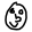

In [8]:
# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset
import quick_torch as qt
import torchvision.transforms.v2 as T

transform_ds = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

def get_ds(file_path, transform=transform_ds):
    ic(file_path)
    categories = [qt.Category.FACE]
    dataset_ = qt.QuickDraw(
        root=DATA_PATH,
        categories=categories,
        transform=transform,
        download=True,
        recognized=True,
    )
    path_dataset = Path(file_path)
    dataset_.data = np.load(path_dataset).reshape(-1, 28, 28)
    dataset_.targets = np.ones(len(dataset_.data), dtype=int)
    dataset = dataset_.get_train_data()
    ic(len(dataset))

    return ModelDataset(dataset)

DS_PATH = WGAN_PATH / "dataset" / "cleaned" / f"{DS_NAME}.npy"
ds_models = get_ds(DS_PATH)

ds_models.get(0)

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k=0$, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor inicial.

In [9]:
from bwb.sgdw.utils import step_scheduler
window = 5

def test_gamma(gamma):

    for t in range(window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 50
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 100
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 300
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 500
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 1_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 3_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 5_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    # init = 10_000
    # for t in range(init, init+window):
    #     print(f"{t = :_}; {gamma(t) = :.2%}")
    # print()

    # init = 20_000
    # for t in range(init, init+window):
    #     print(f"{t = :_}; {gamma(t) = :.2%}")
    # print()

    # init = 50_000
    # for t in range(init, init+window):
    #     print(f"{t = :_}; {gamma(t) = :.2%}")
    # print()

    # init = 100_000
    # for t in range(init, init+window):
    #     print(f"{t = :_}; {gamma(t) = :.2%}")


_a = 3
_eps = 0.2
params = dict(a=_a, b=_a+1e-2, c=0.5+_eps)
# params = dict(a=1, b=1, c=1)

gamma = step_scheduler(**params)

test_gamma(step_scheduler(**params))

t = 0; gamma(t) = 99.67%
t = 1; gamma(t) = 87.36%
t = 2; gamma(t) = 78.19%
t = 3; gamma(t) = 71.06%
t = 4; gamma(t) = 65.32%

t = 50; gamma(t) = 18.19%
t = 51; gamma(t) = 17.96%
t = 52; gamma(t) = 17.74%
t = 53; gamma(t) = 17.52%
t = 54; gamma(t) = 17.31%

t = 100; gamma(t) = 11.56%
t = 101; gamma(t) = 11.48%
t = 102; gamma(t) = 11.40%
t = 103; gamma(t) = 11.33%
t = 104; gamma(t) = 11.26%

t = 300; gamma(t) = 5.47%
t = 301; gamma(t) = 5.46%
t = 302; gamma(t) = 5.45%
t = 303; gamma(t) = 5.44%
t = 304; gamma(t) = 5.42%

t = 500; gamma(t) = 3.85%
t = 501; gamma(t) = 3.84%
t = 502; gamma(t) = 3.83%
t = 503; gamma(t) = 3.83%
t = 504; gamma(t) = 3.82%

t = 1_000; gamma(t) = 2.37%
t = 1_001; gamma(t) = 2.37%
t = 1_002; gamma(t) = 2.37%
t = 1_003; gamma(t) = 2.37%
t = 1_004; gamma(t) = 2.37%

t = 3_000; gamma(t) = 1.10%
t = 3_001; gamma(t) = 1.10%
t = 3_002; gamma(t) = 1.10%
t = 3_003; gamma(t) = 1.10%
t = 3_004; gamma(t) = 1.10%

t = 5_000; gamma(t) = 0.77%
t = 5_001; gamma(t) = 0.77%
t = 5_0

# Baricentro de imágenes

In [10]:
pi_n = UniformDiscreteSampler[DistributionDraw]().fit(models=ds_models)

In [11]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=pi_n,
    step_scheduler=step_scheduler(**params),
    batch_size=S_k,
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

(DetentionParameters(tol=0.00e+00, max_iter=88, max_time=∞),
 History(pos_wgt=False, distr=False, pos_wgt_samp=False, distr_samp=False, len=0))

In [12]:
from bwb.sgdw.plotters import PlotterComparison

plotter_comp = PlotterComparison(
    dist_draw_sgdw,
    plot_every=50,
    n_cols=12,
    n_rows=2,
    cmap="binary_r"
)

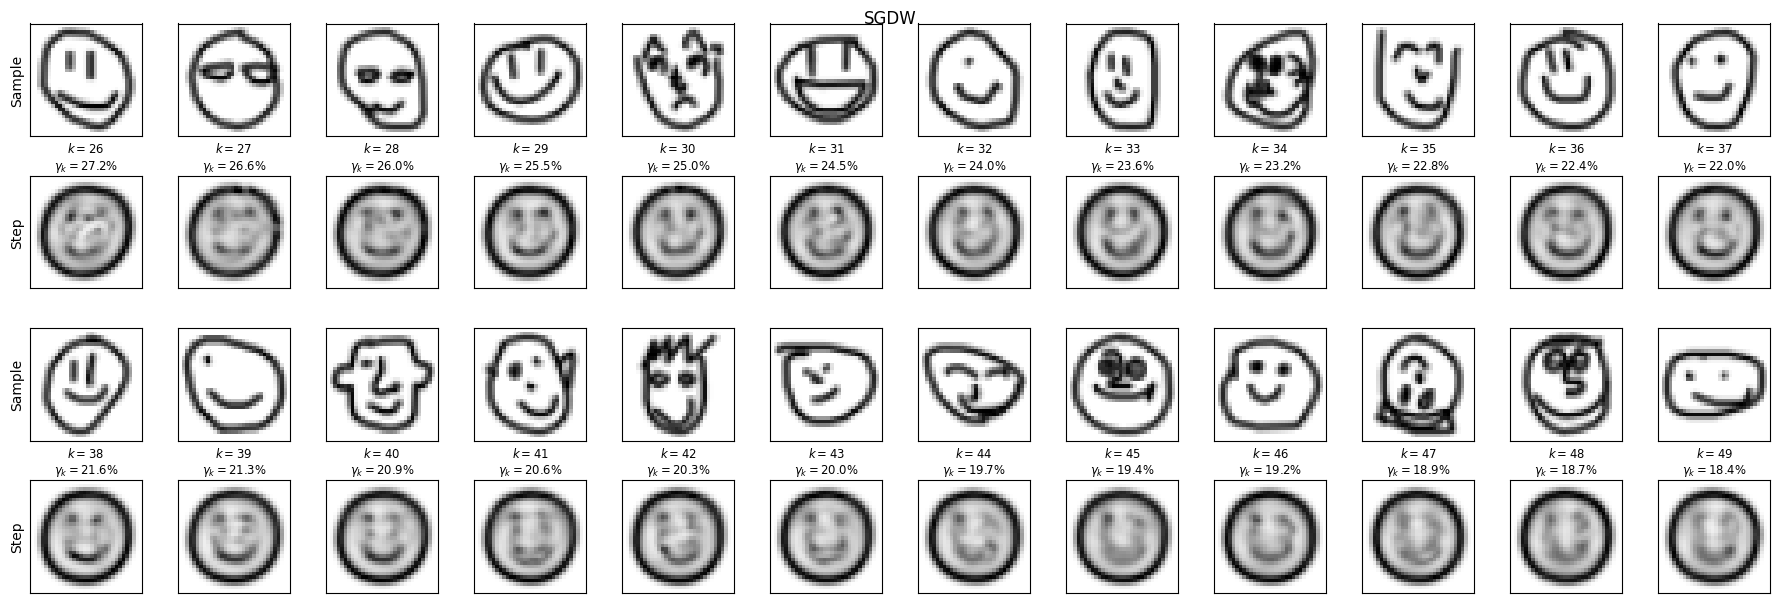

IterationParameters(k=88, w_dist=∞, t=0:00:27.74, Δt=258.04 [ms])

In [13]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' DS barycenter")
bar = plotter_comp.run(
    include_dict=dict(total_time=True),
)
dist_draw_sgdw.iter_params

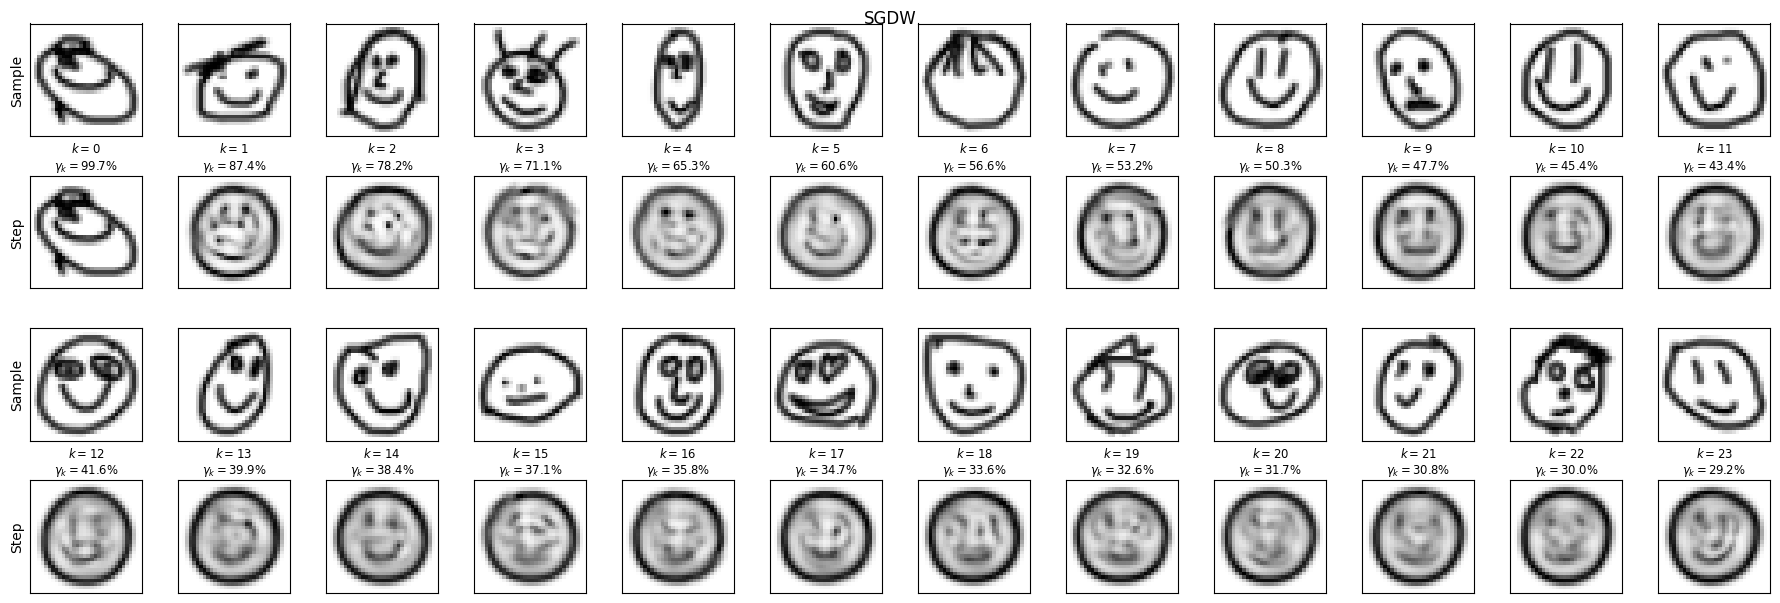

In [14]:
_ = plotter_comp.plot(0)